In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from linearmodels import PanelOLS
import statsmodels.api as sm

In [2]:
data = pd.read_csv("Data/master_data_es.csv")
data.drop(columns=["Unnamed: 0"], inplace=True)
data = data.dropna()

In [3]:
#sum stats
sum_stats = data[['price', 'vol', 'return', 'share_passive', '3day_vol', '5day_vol', '7day_vol']].describe()
sum_stats

,price,vol,return,share_passive,3day_vol,5day_vol,7day_vol
count,393682.000000,3.936820e+05,393682.000000,393682.000000,393682.000000,393682.000000,393682.000000
mean,60.052710,2.115554e+06,-0.000317,0.140161,1.829848,3.064781,4.295161
std,171.480715,9.881273e+06,0.045989,0.122822,6.120660,9.592105,13.190782
min,0.020100,0.000000e+00,-0.804171,0.000004,0.000000,0.000000,0.001365
25%,7.750000,1.485918e+05,-0.017616,0.040576,0.210713,0.397083,0.571075
50%,22.540000,4.956950e+05,-0.000424,0.118746,0.593549,1.061061,1.509812
75%,60.380000,1.498748e+06,0.015756,0.182484,1.613722,2.765787,3.898245
max,8382.630000,2.081916e+09,5.382716,0.939402,648.869173,795.567813,940.324454


In [4]:
total_tickers = data['ticker'].unique().tolist()
print(len(total_tickers))

3999


In [5]:
data['passive_q'] = pd.qcut(data['share_passive'], q=4, labels=False) + 1

In [6]:
avg_3volatility = (data.groupby(['days_from_earn', 'passive_q'])['3day_vol'].mean().reset_index())

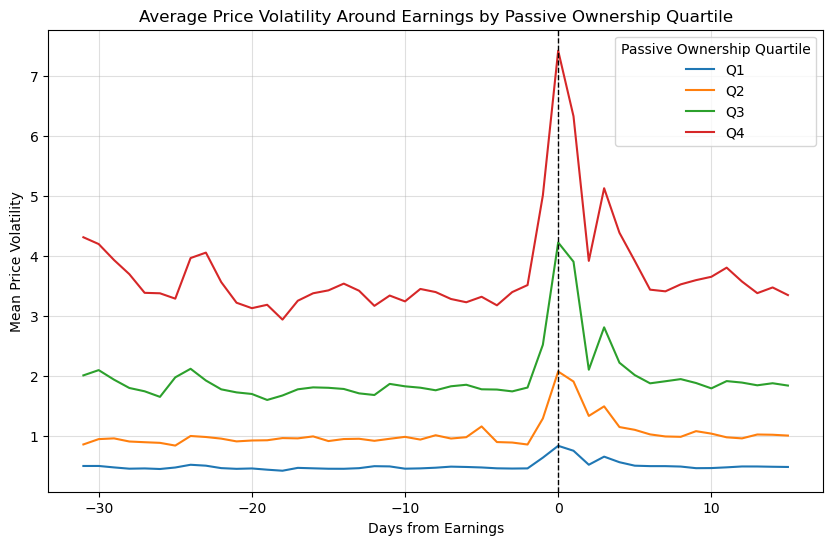

In [7]:
plt.figure(figsize=(10,6))
for q in sorted(data['passive_q'].unique()):
    subset = avg_3volatility[avg_3volatility['passive_q'] == q]
    plt.plot(subset['days_from_earn'], subset['3day_vol'], label=f'Q{q}')

plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title('Average Price Volatility Around Earnings by Passive Ownership Quartile')
plt.xlabel('Days from Earnings')
plt.ylabel('Mean Price Volatility')
plt.legend(title='Passive Ownership Quartile')
plt.grid(True, alpha = 0.4)
plt.savefig("Graphs/3vol_4q.png")
plt.show()

In [8]:
avg_5volatility = (data.groupby(['days_from_earn', 'passive_q'])['5day_vol'].mean().reset_index())

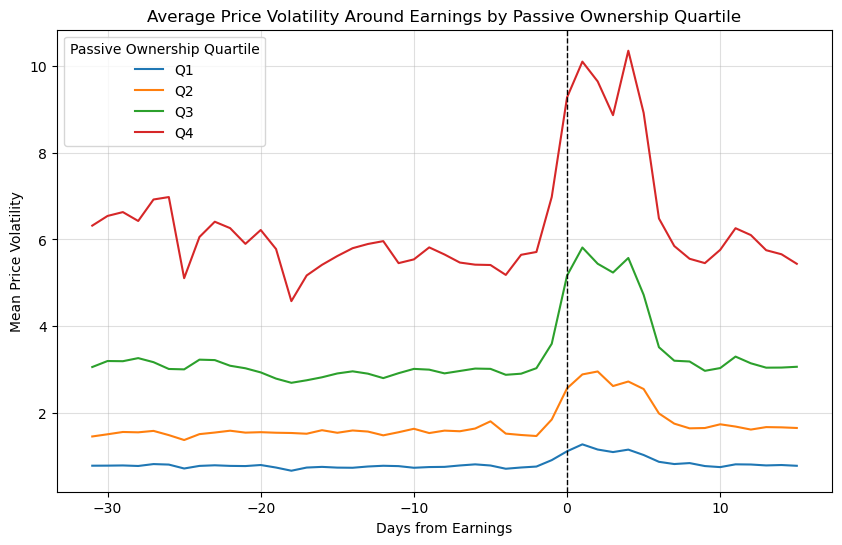

In [9]:
plt.figure(figsize=(10,6))
for q in sorted(data['passive_q'].unique()):
    subset = avg_5volatility[avg_5volatility['passive_q'] == q]
    plt.plot(subset['days_from_earn'], subset['5day_vol'], label=f'Q{q}')

plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title('Average Price Volatility Around Earnings by Passive Ownership Quartile')
plt.xlabel('Days from Earnings')
plt.ylabel('Mean Price Volatility')
plt.legend(title='Passive Ownership Quartile')
plt.grid(True, alpha = 0.4)
plt.savefig("Graphs/5vol_4q.png")
plt.show()

In [10]:
avg_30volatility = (data.groupby(['days_from_earn', 'passive_q'])['7day_vol'].mean().reset_index())

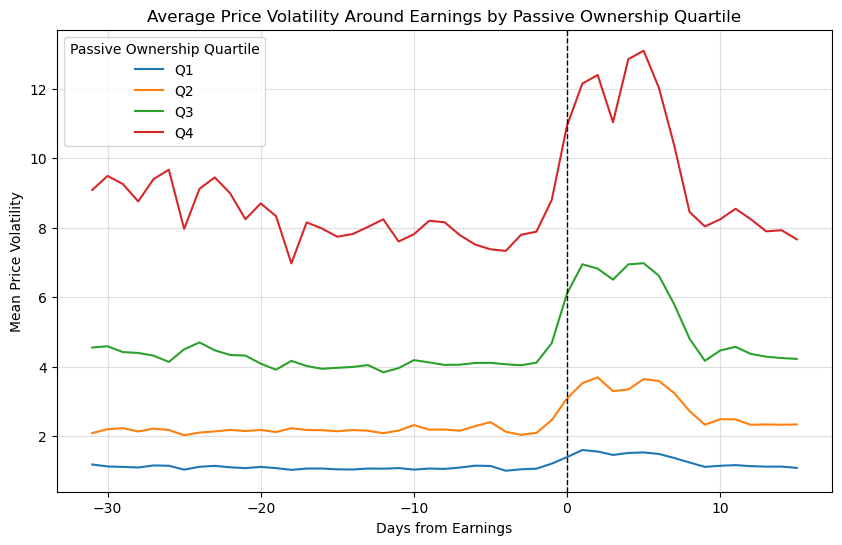

In [11]:
plt.figure(figsize=(10,6))
for q in sorted(data['passive_q'].unique()):
    subset = avg_30volatility[avg_30volatility['passive_q'] == q]
    plt.plot(subset['days_from_earn'], subset['7day_vol'], label=f'Q{q}')

plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title('Average Price Volatility Around Earnings by Passive Ownership Quartile')
plt.xlabel('Days from Earnings')
plt.ylabel('Mean Price Volatility')
plt.legend(title='Passive Ownership Quartile')
plt.grid(True, alpha = 0.4)
plt.savefig("Graphs/7vol_4q.png")
plt.show()

In [12]:
def event_study(data, level, cov, entity_fe = False, time_fe = False, cluster = False):
    if level == 3:
        for k in range(-29, 16):
            data[f'day_{k}'] = (data['days_from_earn'] == k).astype(int)
        data['Date'] = pd.to_datetime(data['Date'])
        df = data.set_index(['ticker', 'Date'])
        event_dummies = [f'day_{k}' for k in range(-29, 16) if k != -1]
        for k in range(-29, 16):
            if k != -1:
                df[f'day_{k}_passive'] = df[f'day_{k}'] * df['share_passive']
            
        passive = ['share_passive']

        X = df[event_dummies + [f'{d}_passive' for d in event_dummies] + passive]
        Y = df['3day_vol']
        model = PanelOLS(Y, X, entity_effects=entity_fe, time_effects=time_fe)
        res = model.fit(cov_type=cov, cluster_entity = cluster)
        return res
    elif level == 5:
        for k in range(-29, 16):
            data[f'day_{k}'] = (data['days_from_earn'] == k).astype(int)
        data['Date'] = pd.to_datetime(data['Date'])
        df = data.set_index(['ticker', 'Date'])
        event_dummies = [f'day_{k}' for k in range(-29, 16) if k != -1]
        for k in range(-29, 16):
            if k != -1:
                df[f'day_{k}_passive'] = df[f'day_{k}'] * df['share_passive']
            
        passive = ['share_passive']

        X = df[event_dummies + [f'{d}_passive' for d in event_dummies] + passive]
        Y = df['5day_vol']
        model = PanelOLS(Y, X, entity_effects=entity_fe, time_effects=time_fe)
        res = model.fit(cov_type=cov, cluster_entity = cluster)
        return res
    elif level == 7:
        for k in range(-29, 16):
            data[f'day_{k}'] = (data['days_from_earn'] == k).astype(int)
        data['Date'] = pd.to_datetime(data['Date'])
        df = data.set_index(['ticker', 'Date'])
        event_dummies = [f'day_{k}' for k in range(-29, 16) if k != -1]
        for k in range(-29, 16):
            if k != -1:
                df[f'day_{k}_passive'] = df[f'day_{k}'] * df['share_passive']
             
        passive = ['share_passive']

        X = df[event_dummies + [f'{d}_passive' for d in event_dummies] + passive]
        Y = df['7day_vol']
        model = PanelOLS(Y, X, entity_effects=entity_fe, time_effects=time_fe)
        res = model.fit(cov_type=cov, cluster_entity = cluster)
        return res

In [13]:
res = event_study(data, 3, 'clustered', False, False, True)
print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               3day_vol   R-squared:                        0.1172
Estimator:                   PanelOLS   R-squared (Between):              0.2098
No. Observations:              393682   R-squared (Within):               0.0120
Date:                Sun, Nov 02 2025   R-squared (Overall):              0.1172
Time:                        19:13:01   Log-likelihood                -1.264e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      586.83
Entities:                        3999   P-value                           0.0000
Avg Obs:                       98.445   Distribution:               F(89,393593)
Min Obs:                       2.0000                                           
Max Obs:                       136.00   F-statistic (robust):             24.753
                            

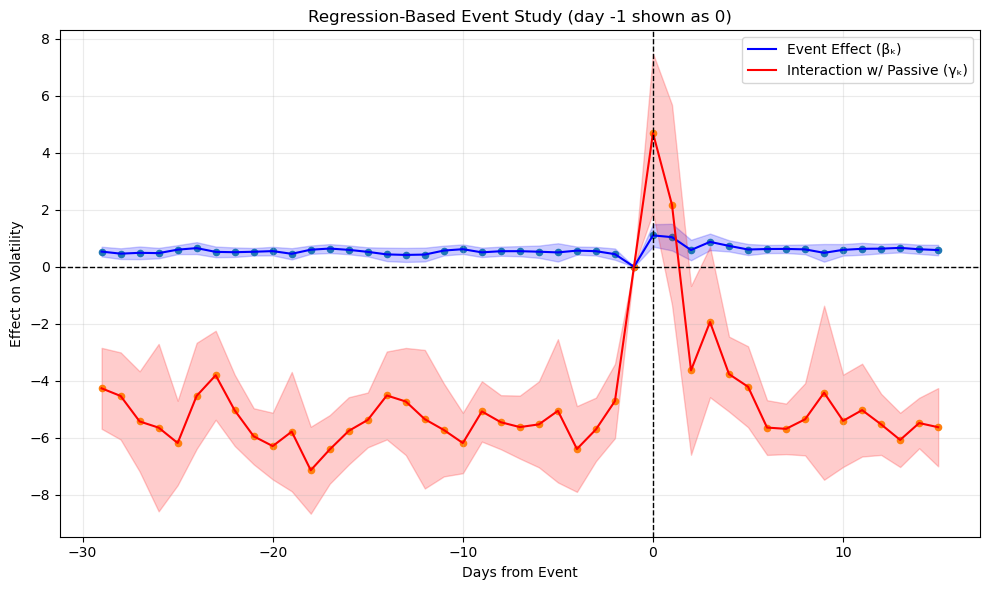

In [14]:
days = list(range(-29, 16))

def get_coef(key):
    return float(res.params.get(key, 0.0))

def get_se(key):
    return float(res.std_errors.get(key, 0.0))

# Build arrays for betas and gammas, with explicit 0 at day -1
betas = []
beta_se = []
gammas = []
gamma_se = []

for k in days:
    if k == -1:
        # omitted baseline: coefficient = 0, se = 0
        betas.append(0.0)
        beta_se.append(0.0)
        gammas.append(0.0)
        gamma_se.append(0.0)
    else:
        betas.append(get_coef(f'day_{k}'))
        beta_se.append(get_se(f'day_{k}'))
        gammas.append(get_coef(f'day_{k}_passive'))
        gamma_se.append(get_se(f'day_{k}_passive'))

betas = np.array(betas)
beta_se = np.array(beta_se)
gammas = np.array(gammas)
gamma_se = np.array(gamma_se)

# 95% CI bounds
beta_lower = betas - 1.96 * beta_se
beta_upper = betas + 1.96 * beta_se
gamma_lower = gammas - 1.96 * gamma_se
gamma_upper = gammas + 1.96 * gamma_se

# Plot: lines + shaded 95% CI + dots
plt.figure(figsize=(10,6))

# βk
plt.plot(days, betas, label='Event Effect (βₖ)', linewidth=1.5, color='blue')
plt.fill_between(days, beta_lower, beta_upper, alpha=0.2, color='blue')
plt.scatter(days, betas, s=20)

# γk
plt.plot(days, gammas, label='Interaction w/ Passive (γₖ)', linewidth=1.5, color='red')
plt.fill_between(days, gamma_lower, gamma_upper, alpha=0.2, color='red')
plt.scatter(days, gammas, s=20)

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.xlabel('Days from Event')
plt.ylabel('Effect on Volatility')
plt.title('Regression-Based Event Study (day -1 shown as 0)')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("Graphs/3vol_es.png")
plt.show()

In [15]:
res = event_study(data, 5, 'clustered', False, False, True)
print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               5day_vol   R-squared:                        0.1310
Estimator:                   PanelOLS   R-squared (Between):              0.2078
No. Observations:              393682   R-squared (Within):               0.0116
Date:                Sun, Nov 02 2025   R-squared (Overall):              0.1310
Time:                        19:13:14   Log-likelihood                 -1.44e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      666.50
Entities:                        3999   P-value                           0.0000
Avg Obs:                       98.445   Distribution:               F(89,393593)
Min Obs:                       2.0000                                           
Max Obs:                       136.00   F-statistic (robust):             25.995
                            

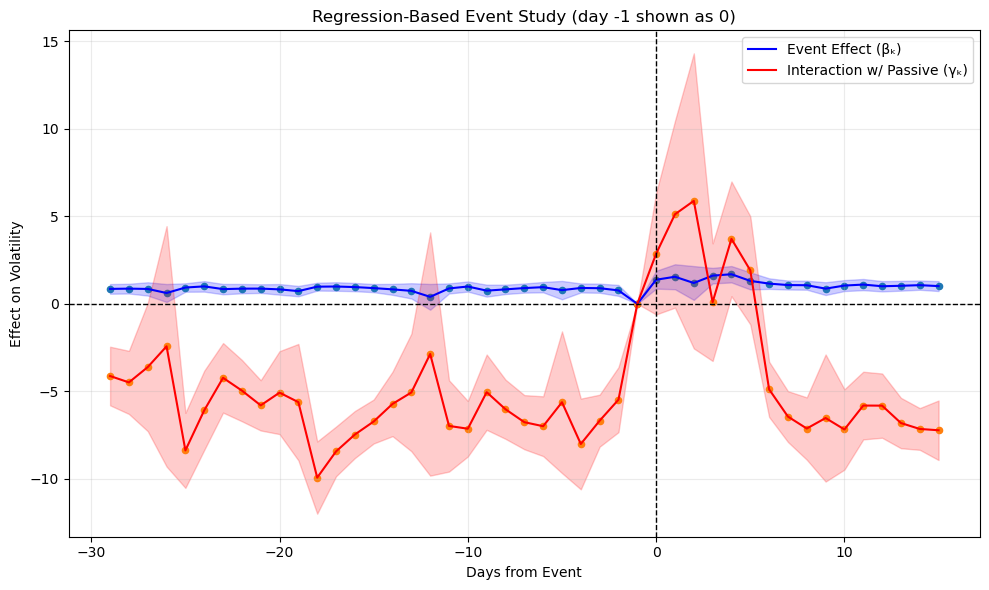

In [16]:
days = list(range(-29, 16))

def get_coef(key):
    return float(res.params.get(key, 0.0))

def get_se(key):
    return float(res.std_errors.get(key, 0.0))

# Build arrays for betas and gammas, with explicit 0 at day -1
betas = []
beta_se = []
gammas = []
gamma_se = []

for k in days:
    if k == -1:
        # omitted baseline: coefficient = 0, se = 0
        betas.append(0.0)
        beta_se.append(0.0)
        gammas.append(0.0)
        gamma_se.append(0.0)
    else:
        betas.append(get_coef(f'day_{k}'))
        beta_se.append(get_se(f'day_{k}'))
        gammas.append(get_coef(f'day_{k}_passive'))
        gamma_se.append(get_se(f'day_{k}_passive'))

betas = np.array(betas)
beta_se = np.array(beta_se)
gammas = np.array(gammas)
gamma_se = np.array(gamma_se)

# 95% CI bounds
beta_lower = betas - 1.96 * beta_se
beta_upper = betas + 1.96 * beta_se
gamma_lower = gammas - 1.96 * gamma_se
gamma_upper = gammas + 1.96 * gamma_se

# Plot: lines + shaded 95% CI + dots
plt.figure(figsize=(10,6))

# βk
plt.plot(days, betas, label='Event Effect (βₖ)', linewidth=1.5, color='blue')
plt.fill_between(days, beta_lower, beta_upper, alpha=0.2, color='blue')
plt.scatter(days, betas, s=20)

# γk
plt.plot(days, gammas, label='Interaction w/ Passive (γₖ)', linewidth=1.5, color='red')
plt.fill_between(days, gamma_lower, gamma_upper, alpha=0.2, color='red')
plt.scatter(days, gammas, s=20)

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.xlabel('Days from Event')
plt.ylabel('Effect on Volatility')
plt.title('Regression-Based Event Study (day -1 shown as 0)')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("Graphs/5vol_es.png")
plt.show()

In [17]:
res = event_study(data, 7, 'clustered', False, False, True)
print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               7day_vol   R-squared:                        0.1347
Estimator:                   PanelOLS   R-squared (Between):              0.2066
No. Observations:              393682   R-squared (Within):               0.0091
Date:                Sun, Nov 02 2025   R-squared (Overall):              0.1347
Time:                        19:13:28   Log-likelihood                -1.565e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      688.31
Entities:                        3999   P-value                           0.0000
Avg Obs:                       98.445   Distribution:               F(89,393593)
Min Obs:                       2.0000                                           
Max Obs:                       136.00   F-statistic (robust):             26.630
                            

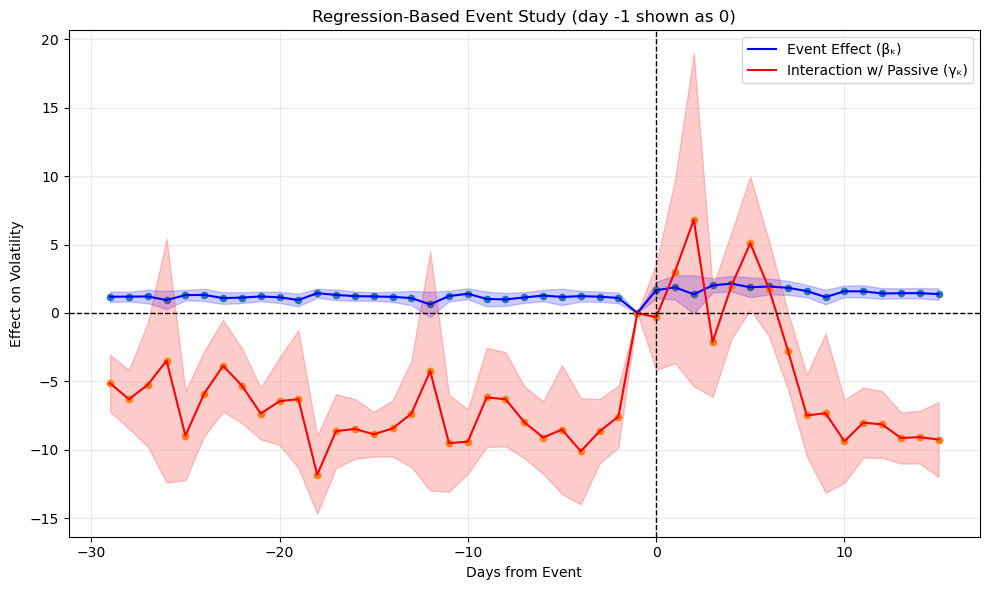

In [18]:
days = list(range(-29, 16))

def get_coef(key):
    return float(res.params.get(key, 0.0))

def get_se(key):
    return float(res.std_errors.get(key, 0.0))

# Build arrays for betas and gammas, with explicit 0 at day -1
betas = []
beta_se = []
gammas = []
gamma_se = []

for k in days:
    if k == -1:
        # omitted baseline: coefficient = 0, se = 0
        betas.append(0.0)
        beta_se.append(0.0)
        gammas.append(0.0)
        gamma_se.append(0.0)
    else:
        betas.append(get_coef(f'day_{k}'))
        beta_se.append(get_se(f'day_{k}'))
        gammas.append(get_coef(f'day_{k}_passive'))
        gamma_se.append(get_se(f'day_{k}_passive'))

betas = np.array(betas)
beta_se = np.array(beta_se)
gammas = np.array(gammas)
gamma_se = np.array(gamma_se)

# 95% CI bounds
beta_lower = betas - 1.96 * beta_se
beta_upper = betas + 1.96 * beta_se
gamma_lower = gammas - 1.96 * gamma_se
gamma_upper = gammas + 1.96 * gamma_se

# Plot: lines + shaded 95% CI + dots
plt.figure(figsize=(10,6))

# βk
plt.plot(days, betas, label='Event Effect (βₖ)', linewidth=1.5, color='blue')
plt.fill_between(days, beta_lower, beta_upper, alpha=0.2, color='blue')
plt.scatter(days, betas, s=20)

# γk
plt.plot(days, gammas, label='Interaction w/ Passive (γₖ)', linewidth=1.5, color='red')
plt.fill_between(days, gamma_lower, gamma_upper, alpha=0.2, color='red')
plt.scatter(days, gammas, s=20)

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.xlabel('Days from Event')
plt.ylabel('Effect on Volatility')
plt.title('Regression-Based Event Study (day -1 shown as 0)')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("Graphs/7vol_es.png")
plt.show()

In [19]:
data_cont = pd.read_csv("Data/master_data_es_controls.csv")
data_cont.drop(columns=["Unnamed: 0"], inplace=True)
data_cont = data_cont.dropna()

In [20]:
data_cont.columns

Index(['Date', 'ticker', 'price', 'vol', 'return', 'share_passive',
       'shares_outstanding', 'days_from_earn', 'sp_ret',
       'earnings_date_nearest', '3day_vol', '5day_vol', '7day_vol',
       'abnormal_return_ar1', 'abnormal_return_mkt', 'abnormal_return_sp',
       'in_sp', 'sector', 'ta', 'cash_sinvest', 'long_debt_tot', 'rev',
       'net_inc', 'eps'],
      dtype='object')

In [21]:
sum_stats_cont = data_cont[['price', 'vol', 'return', 'share_passive', '3day_vol', '5day_vol', '7day_vol']].describe()
sum_stats_cont

,price,vol,return,share_passive,3day_vol,5day_vol,7day_vol
count,328958.000000,3.289580e+05,328958.000000,328958.000000,328958.000000,328958.000000,328958.000000
mean,60.101314,2.135639e+06,-0.000437,0.140011,1.846708,3.091972,4.333843
std,175.928206,9.490954e+06,0.046812,0.121822,6.331001,9.915770,13.654893
min,0.020100,0.000000e+00,-0.804171,0.000004,0.000000,0.000000,0.001365
25%,7.070000,1.713648e+05,-0.018446,0.036811,0.205183,0.385487,0.552208
50%,21.130000,5.321630e+05,-0.000629,0.119069,0.590931,1.060601,1.507067
75%,61.360000,1.534196e+06,0.016152,0.183640,1.640152,2.808977,3.954116
max,8382.630000,2.081916e+09,5.382716,0.939402,648.869173,795.567813,940.324454


In [22]:
for k in range(-29, 16):
    data_cont[f'day_{k}'] = (data_cont['days_from_earn'] == k).astype(int)

data_cont['Date'] = pd.to_datetime(data_cont['Date'])
df = data_cont.set_index(['ticker', 'Date'])

event_dummies = [f'day_{k}' for k in range(-29, 16) if k != -1]
interaction_terms = [f'{d}_passive' for d in event_dummies]

for k in range(-29, 16):
    if k != -1:
        df[f'day_{k}_passive'] = df[f'day_{k}'] * df['share_passive']

sector_dummies = pd.get_dummies(df['sector'], prefix='sector', drop_first=True)
df = pd.concat([df, sector_dummies], axis=1)

controls = ['share_passive', 'ta', 'cash_sinvest', 'long_debt_tot', 'rev', 'net_inc', 'eps', 'vol']

X_vars = event_dummies + interaction_terms + controls + list(sector_dummies.columns)
X = df[X_vars]
Y = df['3day_vol']

model = PanelOLS(Y, X, entity_effects=False, time_effects=False)
res = model.fit(cov_type='clustered', cluster_entity=True)

print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               3day_vol   R-squared:                        0.1810
Estimator:                   PanelOLS   R-squared (Between):              0.3800
No. Observations:              328958   R-squared (Within):              -0.0446
Date:                Sun, Nov 02 2025   R-squared (Overall):              0.1810
Time:                        19:13:44   Log-likelihood                -1.054e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      685.72
Entities:                        3502   P-value                           0.0000
Avg Obs:                       93.934   Distribution:              F(106,328852)
Min Obs:                       1.0000                                           
Max Obs:                       136.00   F-statistic (robust):             24.928
                            

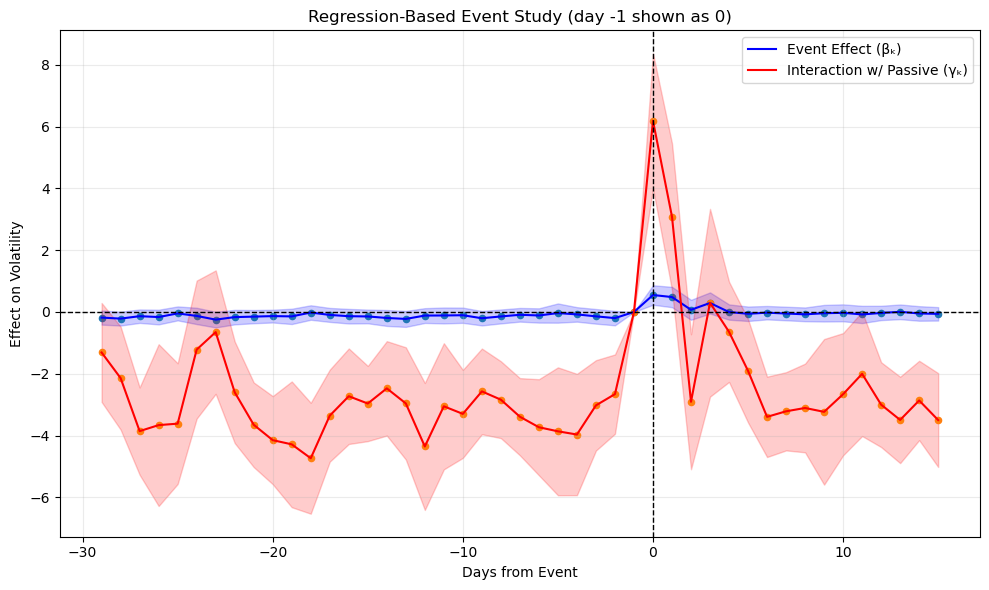

In [23]:
days = list(range(-29, 16))

def get_coef(key):
    return float(res.params.get(key, 0.0))

def get_se(key):
    return float(res.std_errors.get(key, 0.0))

# Build arrays for betas and gammas, with explicit 0 at day -1
betas = []
beta_se = []
gammas = []
gamma_se = []

for k in days:
    if k == -1:
        # omitted baseline: coefficient = 0, se = 0
        betas.append(0.0)
        beta_se.append(0.0)
        gammas.append(0.0)
        gamma_se.append(0.0)
    else:
        betas.append(get_coef(f'day_{k}'))
        beta_se.append(get_se(f'day_{k}'))
        gammas.append(get_coef(f'day_{k}_passive'))
        gamma_se.append(get_se(f'day_{k}_passive'))

betas = np.array(betas)
beta_se = np.array(beta_se)
gammas = np.array(gammas)
gamma_se = np.array(gamma_se)

# 95% CI bounds
beta_lower = betas - 1.96 * beta_se
beta_upper = betas + 1.96 * beta_se
gamma_lower = gammas - 1.96 * gamma_se
gamma_upper = gammas + 1.96 * gamma_se

# Plot: lines + shaded 95% CI + dots
plt.figure(figsize=(10,6))

# βk
plt.plot(days, betas, label='Event Effect (βₖ)', linewidth=1.5, color='blue')
plt.fill_between(days, beta_lower, beta_upper, alpha=0.2, color='blue')
plt.scatter(days, betas, s=20)

# γk
plt.plot(days, gammas, label='Interaction w/ Passive (γₖ)', linewidth=1.5, color='red')
plt.fill_between(days, gamma_lower, gamma_upper, alpha=0.2, color='red')
plt.scatter(days, gammas, s=20)

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.xlabel('Days from Event')
plt.ylabel('Effect on Volatility')
plt.title('Regression-Based Event Study (day -1 shown as 0)')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("Graphs/3vol_es_cont.png")
plt.show()

In [24]:
for k in range(-29, 16):
    data_cont[f'day_{k}'] = (data_cont['days_from_earn'] == k).astype(int)

data_cont['Date'] = pd.to_datetime(data_cont['Date'])
df = data_cont.set_index(['ticker', 'Date'])

event_dummies = [f'day_{k}' for k in range(-29, 16) if k != -1]
interaction_terms = [f'{d}_passive' for d in event_dummies]

for k in range(-29, 16):
    if k != -1:
        df[f'day_{k}_passive'] = df[f'day_{k}'] * df['share_passive']

sector_dummies = pd.get_dummies(df['sector'], prefix='sector', drop_first=True)
df = pd.concat([df, sector_dummies], axis=1)

controls = ['share_passive', 'ta', 'cash_sinvest', 'long_debt_tot', 'rev', 'net_inc', 'eps', 'vol']

X_vars = event_dummies + interaction_terms + controls + list(sector_dummies.columns)
X = df[X_vars]
Y = df['5day_vol']

model = PanelOLS(Y, X, entity_effects=False, time_effects=False)
res = model.fit(cov_type='clustered', cluster_entity=True)

print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               5day_vol   R-squared:                        0.2050
Estimator:                   PanelOLS   R-squared (Between):              0.3796
No. Observations:              328958   R-squared (Within):              -0.0692
Date:                Sun, Nov 02 2025   R-squared (Overall):              0.2050
Time:                        19:13:58   Log-likelihood                -1.199e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      800.02
Entities:                        3502   P-value                           0.0000
Avg Obs:                       93.934   Distribution:              F(106,328852)
Min Obs:                       1.0000                                           
Max Obs:                       136.00   F-statistic (robust):             25.755
                            

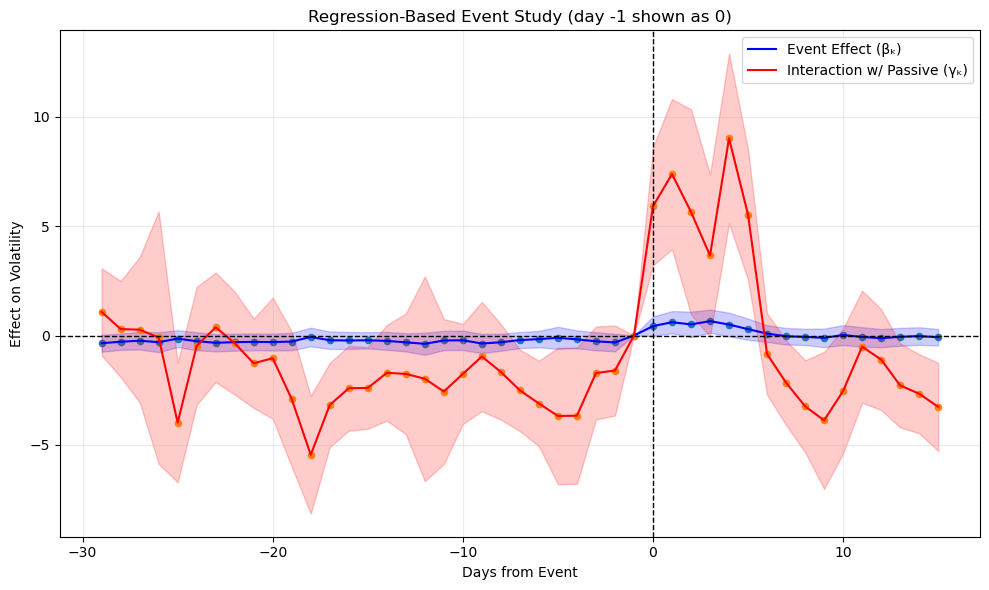

In [25]:
days = list(range(-29, 16))

def get_coef(key):
    return float(res.params.get(key, 0.0))

def get_se(key):
    return float(res.std_errors.get(key, 0.0))

# Build arrays for betas and gammas, with explicit 0 at day -1
betas = []
beta_se = []
gammas = []
gamma_se = []

for k in days:
    if k == -1:
        # omitted baseline: coefficient = 0, se = 0
        betas.append(0.0)
        beta_se.append(0.0)
        gammas.append(0.0)
        gamma_se.append(0.0)
    else:
        betas.append(get_coef(f'day_{k}'))
        beta_se.append(get_se(f'day_{k}'))
        gammas.append(get_coef(f'day_{k}_passive'))
        gamma_se.append(get_se(f'day_{k}_passive'))

betas = np.array(betas)
beta_se = np.array(beta_se)
gammas = np.array(gammas)
gamma_se = np.array(gamma_se)

# 95% CI bounds
beta_lower = betas - 1.96 * beta_se
beta_upper = betas + 1.96 * beta_se
gamma_lower = gammas - 1.96 * gamma_se
gamma_upper = gammas + 1.96 * gamma_se

# Plot: lines + shaded 95% CI + dots
plt.figure(figsize=(10,6))

# βk
plt.plot(days, betas, label='Event Effect (βₖ)', linewidth=1.5, color='blue')
plt.fill_between(days, beta_lower, beta_upper, alpha=0.2, color='blue')
plt.scatter(days, betas, s=20)

# γk
plt.plot(days, gammas, label='Interaction w/ Passive (γₖ)', linewidth=1.5, color='red')
plt.fill_between(days, gamma_lower, gamma_upper, alpha=0.2, color='red')
plt.scatter(days, gammas, s=20)

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.xlabel('Days from Event')
plt.ylabel('Effect on Volatility')
plt.title('Regression-Based Event Study (day -1 shown as 0)')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("Graphs/5vol_es_cont.png")
plt.show()

In [26]:
for k in range(-29, 16):
    data_cont[f'day_{k}'] = (data_cont['days_from_earn'] == k).astype(int)

data_cont['Date'] = pd.to_datetime(data_cont['Date'])
df = data_cont.set_index(['ticker', 'Date'])

event_dummies = [f'day_{k}' for k in range(-29, 16) if k != -1]
interaction_terms = [f'{d}_passive' for d in event_dummies]

for k in range(-29, 16):
    if k != -1:
        df[f'day_{k}_passive'] = df[f'day_{k}'] * df['share_passive']

sector_dummies = pd.get_dummies(df['sector'], prefix='sector', drop_first=True)
df = pd.concat([df, sector_dummies], axis=1)

controls = ['share_passive', 'ta', 'cash_sinvest', 'long_debt_tot', 'rev', 'net_inc', 'eps', 'vol']

X_vars = event_dummies + interaction_terms + controls + list(sector_dummies.columns)
X = df[X_vars]
Y = df['7day_vol']

model = PanelOLS(Y, X, entity_effects=False, time_effects=False)
res = model.fit(cov_type='clustered', cluster_entity=True)

print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               7day_vol   R-squared:                        0.2131
Estimator:                   PanelOLS   R-squared (Between):              0.3817
No. Observations:              328958   R-squared (Within):              -0.0839
Date:                Sun, Nov 02 2025   R-squared (Overall):              0.2131
Time:                        19:14:13   Log-likelihood                -1.303e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      840.34
Entities:                        3502   P-value                           0.0000
Avg Obs:                       93.934   Distribution:              F(106,328852)
Min Obs:                       1.0000                                           
Max Obs:                       136.00   F-statistic (robust):             25.589
                            

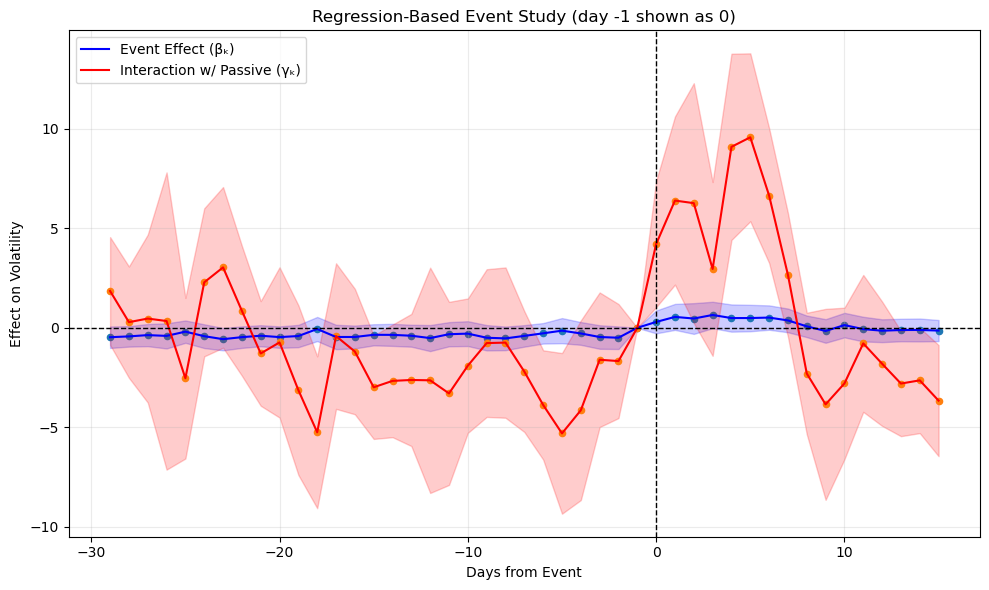

In [27]:
days = list(range(-29, 16))

def get_coef(key):
    return float(res.params.get(key, 0.0))

def get_se(key):
    return float(res.std_errors.get(key, 0.0))

# Build arrays for betas and gammas, with explicit 0 at day -1
betas = []
beta_se = []
gammas = []
gamma_se = []

for k in days:
    if k == -1:
        # omitted baseline: coefficient = 0, se = 0
        betas.append(0.0)
        beta_se.append(0.0)
        gammas.append(0.0)
        gamma_se.append(0.0)
    else:
        betas.append(get_coef(f'day_{k}'))
        beta_se.append(get_se(f'day_{k}'))
        gammas.append(get_coef(f'day_{k}_passive'))
        gamma_se.append(get_se(f'day_{k}_passive'))

betas = np.array(betas)
beta_se = np.array(beta_se)
gammas = np.array(gammas)
gamma_se = np.array(gamma_se)

# 95% CI bounds
beta_lower = betas - 1.96 * beta_se
beta_upper = betas + 1.96 * beta_se
gamma_lower = gammas - 1.96 * gamma_se
gamma_upper = gammas + 1.96 * gamma_se

# Plot: lines + shaded 95% CI + dots
plt.figure(figsize=(10,6))

# βk
plt.plot(days, betas, label='Event Effect (βₖ)', linewidth=1.5, color='blue')
plt.fill_between(days, beta_lower, beta_upper, alpha=0.2, color='blue')
plt.scatter(days, betas, s=20)

# γk
plt.plot(days, gammas, label='Interaction w/ Passive (γₖ)', linewidth=1.5, color='red')
plt.fill_between(days, gamma_lower, gamma_upper, alpha=0.2, color='red')
plt.scatter(days, gammas, s=20)

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.xlabel('Days from Event')
plt.ylabel('Effect on Volatility')
plt.title('Regression-Based Event Study (day -1 shown as 0)')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("Graphs/7vol_es_cont.png")
plt.show()

In [28]:
for k in range(-29, 16):
    data_cont[f'day_{k}'] = (data_cont['days_from_earn'] == k).astype(int)

data_cont['Date'] = pd.to_datetime(data_cont['Date'])
df = data_cont.set_index(['ticker', 'Date'])

event_dummies = [f'day_{k}' for k in range(-29, 16) if k != -1]
interaction_terms = [f'{d}_passive' for d in event_dummies]

for k in range(-29, 16):
    if k != -1:
        df[f'day_{k}_passive'] = df[f'day_{k}'] * df['share_passive']

controls = ['share_passive', 'ta', 'cash_sinvest', 'long_debt_tot', 'rev', 'net_inc', 'eps', 'vol']

X_vars = event_dummies + interaction_terms + controls
X = df[X_vars]
Y = df['3day_vol']

model = PanelOLS(Y, X, entity_effects=True, time_effects=False)
res = model.fit(cov_type='clustered', cluster_entity=True)

print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               3day_vol   R-squared:                        0.0152
Estimator:                   PanelOLS   R-squared (Between):             -0.0243
No. Observations:              328958   R-squared (Within):               0.0152
Date:                Sun, Nov 02 2025   R-squared (Overall):              0.0030
Time:                        19:14:33   Log-likelihood                -9.604e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      52.363
Entities:                        3502   P-value                           0.0000
Avg Obs:                       93.934   Distribution:               F(96,325360)
Min Obs:                       1.0000                                           
Max Obs:                       136.00   F-statistic (robust):             9.5060
                            

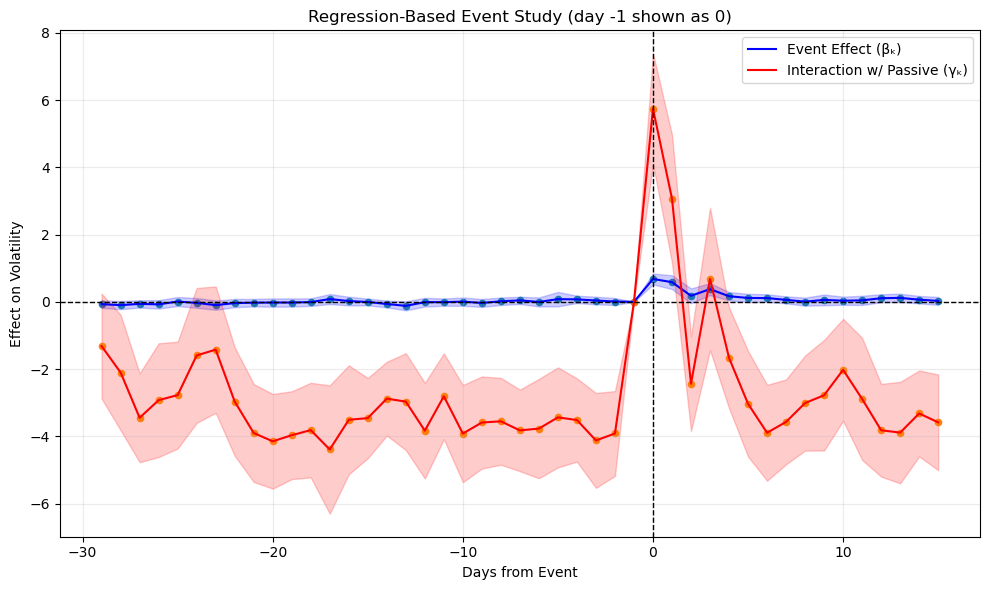

In [29]:
days = list(range(-29, 16))

def get_coef(key):
    return float(res.params.get(key, 0.0))

def get_se(key):
    return float(res.std_errors.get(key, 0.0))

# Build arrays for betas and gammas, with explicit 0 at day -1
betas = []
beta_se = []
gammas = []
gamma_se = []

for k in days:
    if k == -1:
        # omitted baseline: coefficient = 0, se = 0
        betas.append(0.0)
        beta_se.append(0.0)
        gammas.append(0.0)
        gamma_se.append(0.0)
    else:
        betas.append(get_coef(f'day_{k}'))
        beta_se.append(get_se(f'day_{k}'))
        gammas.append(get_coef(f'day_{k}_passive'))
        gamma_se.append(get_se(f'day_{k}_passive'))

betas = np.array(betas)
beta_se = np.array(beta_se)
gammas = np.array(gammas)
gamma_se = np.array(gamma_se)

# 95% CI bounds
beta_lower = betas - 1.96 * beta_se
beta_upper = betas + 1.96 * beta_se
gamma_lower = gammas - 1.96 * gamma_se
gamma_upper = gammas + 1.96 * gamma_se

# Plot: lines + shaded 95% CI + dots
plt.figure(figsize=(10,6))

# βk
plt.plot(days, betas, label='Event Effect (βₖ)', linewidth=1.5, color='blue')
plt.fill_between(days, beta_lower, beta_upper, alpha=0.2, color='blue')
plt.scatter(days, betas, s=20)

# γk
plt.plot(days, gammas, label='Interaction w/ Passive (γₖ)', linewidth=1.5, color='red')
plt.fill_between(days, gamma_lower, gamma_upper, alpha=0.2, color='red')
plt.scatter(days, gammas, s=20)

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.xlabel('Days from Event')
plt.ylabel('Effect on Volatility')
plt.title('Regression-Based Event Study (day -1 shown as 0)')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("Graphs/3vol_es_fe.png")
plt.show()

In [30]:
for k in range(-29, 16):
    data_cont[f'day_{k}'] = (data_cont['days_from_earn'] == k).astype(int)

data_cont['Date'] = pd.to_datetime(data_cont['Date'])
df = data_cont.set_index(['ticker', 'Date'])

event_dummies = [f'day_{k}' for k in range(-29, 16) if k != -1]
interaction_terms = [f'{d}_passive' for d in event_dummies]

for k in range(-29, 16):
    if k != -1:
        df[f'day_{k}_passive'] = df[f'day_{k}'] * df['share_passive']

controls = ['share_passive', 'ta', 'cash_sinvest', 'long_debt_tot', 'rev', 'net_inc', 'eps', 'vol']

X_vars = event_dummies + interaction_terms + controls
X = df[X_vars]
Y = df['5day_vol']

model = PanelOLS(Y, X, entity_effects=True, time_effects=False)
res = model.fit(cov_type='clustered', cluster_entity=True)

print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               5day_vol   R-squared:                        0.0159
Estimator:                   PanelOLS   R-squared (Between):             -0.0089
No. Observations:              328958   R-squared (Within):               0.0159
Date:                Sun, Nov 02 2025   R-squared (Overall):              0.0098
Time:                        19:14:53   Log-likelihood                 -1.08e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      54.670
Entities:                        3502   P-value                           0.0000
Avg Obs:                       93.934   Distribution:               F(96,325360)
Min Obs:                       1.0000                                           
Max Obs:                       136.00   F-statistic (robust):             9.5407
                            

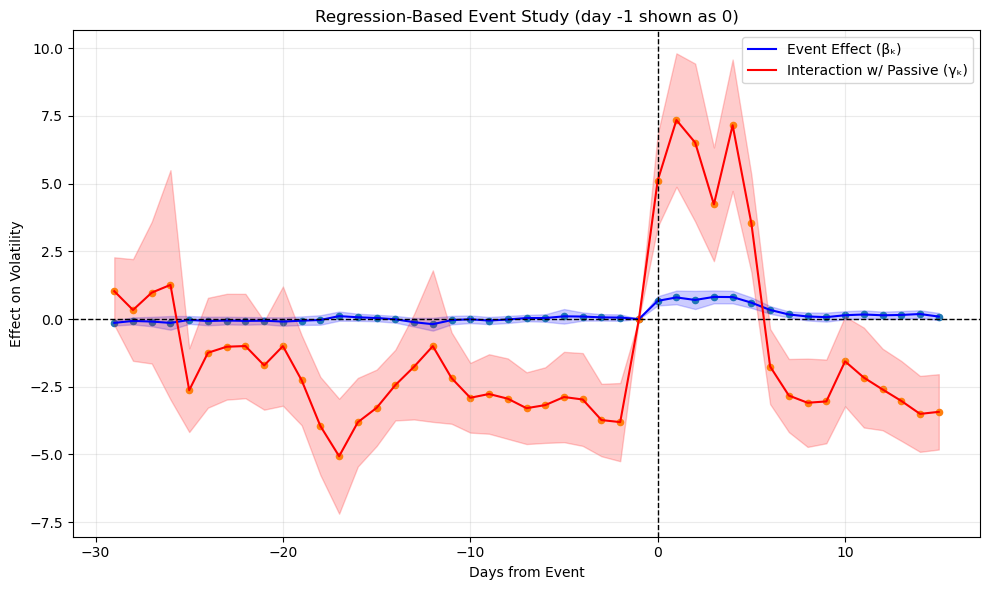

In [31]:
days = list(range(-29, 16))

def get_coef(key):
    return float(res.params.get(key, 0.0))

def get_se(key):
    return float(res.std_errors.get(key, 0.0))

# Build arrays for betas and gammas, with explicit 0 at day -1
betas = []
beta_se = []
gammas = []
gamma_se = []

for k in days:
    if k == -1:
        # omitted baseline: coefficient = 0, se = 0
        betas.append(0.0)
        beta_se.append(0.0)
        gammas.append(0.0)
        gamma_se.append(0.0)
    else:
        betas.append(get_coef(f'day_{k}'))
        beta_se.append(get_se(f'day_{k}'))
        gammas.append(get_coef(f'day_{k}_passive'))
        gamma_se.append(get_se(f'day_{k}_passive'))

betas = np.array(betas)
beta_se = np.array(beta_se)
gammas = np.array(gammas)
gamma_se = np.array(gamma_se)

# 95% CI bounds
beta_lower = betas - 1.96 * beta_se
beta_upper = betas + 1.96 * beta_se
gamma_lower = gammas - 1.96 * gamma_se
gamma_upper = gammas + 1.96 * gamma_se

# Plot: lines + shaded 95% CI + dots
plt.figure(figsize=(10,6))

# βk
plt.plot(days, betas, label='Event Effect (βₖ)', linewidth=1.5, color='blue')
plt.fill_between(days, beta_lower, beta_upper, alpha=0.2, color='blue')
plt.scatter(days, betas, s=20)

# γk
plt.plot(days, gammas, label='Interaction w/ Passive (γₖ)', linewidth=1.5, color='red')
plt.fill_between(days, gamma_lower, gamma_upper, alpha=0.2, color='red')
plt.scatter(days, gammas, s=20)

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.xlabel('Days from Event')
plt.ylabel('Effect on Volatility')
plt.title('Regression-Based Event Study (day -1 shown as 0)')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("Graphs/5vol_es_fe.png")
plt.show()

In [32]:
for k in range(-29, 16):
    data_cont[f'day_{k}'] = (data_cont['days_from_earn'] == k).astype(int)

data_cont['Date'] = pd.to_datetime(data_cont['Date'])
df = data_cont.set_index(['ticker', 'Date'])

event_dummies = [f'day_{k}' for k in range(-29, 16) if k != -1]
interaction_terms = [f'{d}_passive' for d in event_dummies]

for k in range(-29, 16):
    if k != -1:
        df[f'day_{k}_passive'] = df[f'day_{k}'] * df['share_passive']

controls = ['share_passive', 'ta', 'cash_sinvest', 'long_debt_tot', 'rev', 'net_inc', 'eps', 'vol']

X_vars = event_dummies + interaction_terms + controls
X = df[X_vars]
Y = df['7day_vol']

model = PanelOLS(Y, X, entity_effects=True, time_effects=False)
res = model.fit(cov_type='clustered', cluster_entity=True)

print(res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               7day_vol   R-squared:                        0.0140
Estimator:                   PanelOLS   R-squared (Between):              0.0108
No. Observations:              328958   R-squared (Within):               0.0140
Date:                Sun, Nov 02 2025   R-squared (Overall):              0.0193
Time:                        19:15:11   Log-likelihood                -1.174e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      48.201
Entities:                        3502   P-value                           0.0000
Avg Obs:                       93.934   Distribution:               F(96,325360)
Min Obs:                       1.0000                                           
Max Obs:                       136.00   F-statistic (robust):             9.2955
                            

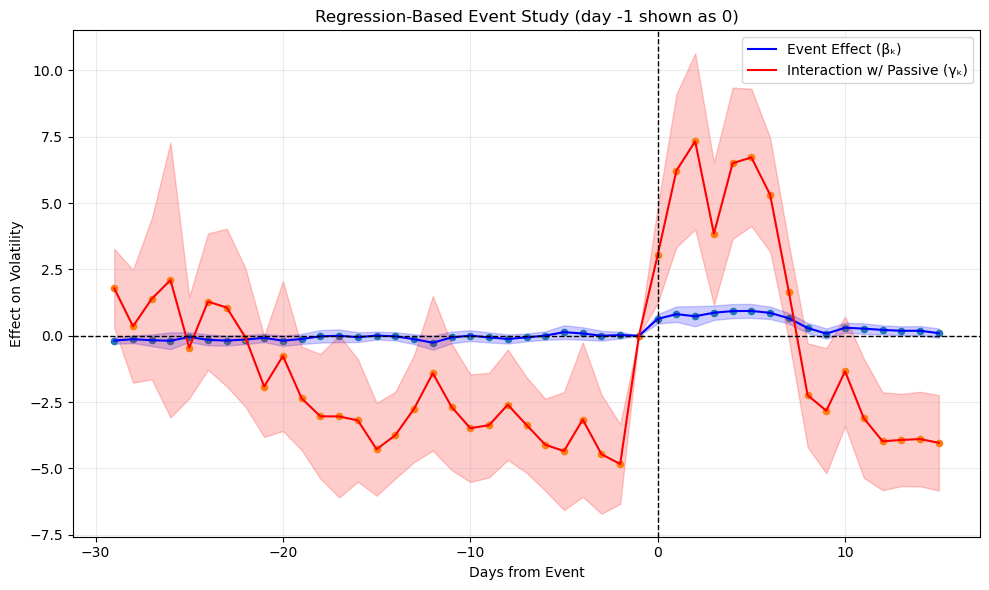

In [33]:
days = list(range(-29, 16))

def get_coef(key):
    return float(res.params.get(key, 0.0))

def get_se(key):
    return float(res.std_errors.get(key, 0.0))

# Build arrays for betas and gammas, with explicit 0 at day -1
betas = []
beta_se = []
gammas = []
gamma_se = []

for k in days:
    if k == -1:
        # omitted baseline: coefficient = 0, se = 0
        betas.append(0.0)
        beta_se.append(0.0)
        gammas.append(0.0)
        gamma_se.append(0.0)
    else:
        betas.append(get_coef(f'day_{k}'))
        beta_se.append(get_se(f'day_{k}'))
        gammas.append(get_coef(f'day_{k}_passive'))
        gamma_se.append(get_se(f'day_{k}_passive'))

betas = np.array(betas)
beta_se = np.array(beta_se)
gammas = np.array(gammas)
gamma_se = np.array(gamma_se)

# 95% CI bounds
beta_lower = betas - 1.96 * beta_se
beta_upper = betas + 1.96 * beta_se
gamma_lower = gammas - 1.96 * gamma_se
gamma_upper = gammas + 1.96 * gamma_se

# Plot: lines + shaded 95% CI + dots
plt.figure(figsize=(10,6))

# βk
plt.plot(days, betas, label='Event Effect (βₖ)', linewidth=1.5, color='blue')
plt.fill_between(days, beta_lower, beta_upper, alpha=0.2, color='blue')
plt.scatter(days, betas, s=20)

# γk
plt.plot(days, gammas, label='Interaction w/ Passive (γₖ)', linewidth=1.5, color='red')
plt.fill_between(days, gamma_lower, gamma_upper, alpha=0.2, color='red')
plt.scatter(days, gammas, s=20)

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.xlabel('Days from Event')
plt.ylabel('Effect on Volatility')
plt.title('Regression-Based Event Study (day -1 shown as 0)')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("Graphs/7vol_es_fe.png")
plt.show()

In [34]:
#Stage one
X = data_cont[['share_passive']]
Z = sm.add_constant(data_cont[['in_sp']])
model1 = sm.OLS(X, Z)
model1_robust = model1.fit(cov_type='HC3')
x_hat = model1_robust.predict(Z)
print(model1_robust.summary())

                            OLS Regression Results                            
Dep. Variable:          share_passive   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                 2.465e+05
Date:                Sun, 02 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:15:13   Log-Likelihood:             2.9449e+05
No. Observations:              328958   AIC:                        -5.890e+05
Df Residuals:                  328956   BIC:                        -5.889e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1122      0.000    590.183      0.0

In [35]:
#stage two
data_cont['passive_hat'] = x_hat

for k in range(-29, 16):
    data_cont[f'day_{k}'] = (data_cont['days_from_earn'] == k).astype(int)

for k in range(-29, 16):
    if k != -1:  
        data_cont[f'day_{k}_passive_hat'] = data_cont[f'day_{k}'] * data_cont['passive_hat']

event_dummies = [f'day_{k}' for k in range(-29, 16) if k != -1]
interaction_terms = [f'day_{k}_passive_hat' for k in range(-29, 16) if k != -1]

controls = ['passive_hat', 'ta', 'cash_sinvest', 'long_debt_tot', 'rev', 'net_inc', 'eps', 'vol']

X_vars = event_dummies + interaction_terms + controls

data_cont['Date'] = pd.to_datetime(data_cont['Date'])
df = data_cont.set_index(['ticker', 'Date'])

Y = df['3day_vol']
X = df[X_vars]

model2 = PanelOLS(Y, X, entity_effects=True, time_effects=False)
res2 = model2.fit(cov_type='clustered', cluster_entity=True)

print(res2.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               3day_vol   R-squared:                        0.0165
Estimator:                   PanelOLS   R-squared (Between):              0.0935
No. Observations:              328958   R-squared (Within):               0.0165
Date:                Sun, Nov 02 2025   R-squared (Overall):              0.0639
Time:                        19:15:31   Log-likelihood                -9.602e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      56.827
Entities:                        3502   P-value                           0.0000
Avg Obs:                       93.934   Distribution:               F(96,325360)
Min Obs:                       1.0000                                           
Max Obs:                       136.00   F-statistic (robust):             8.9653
                            

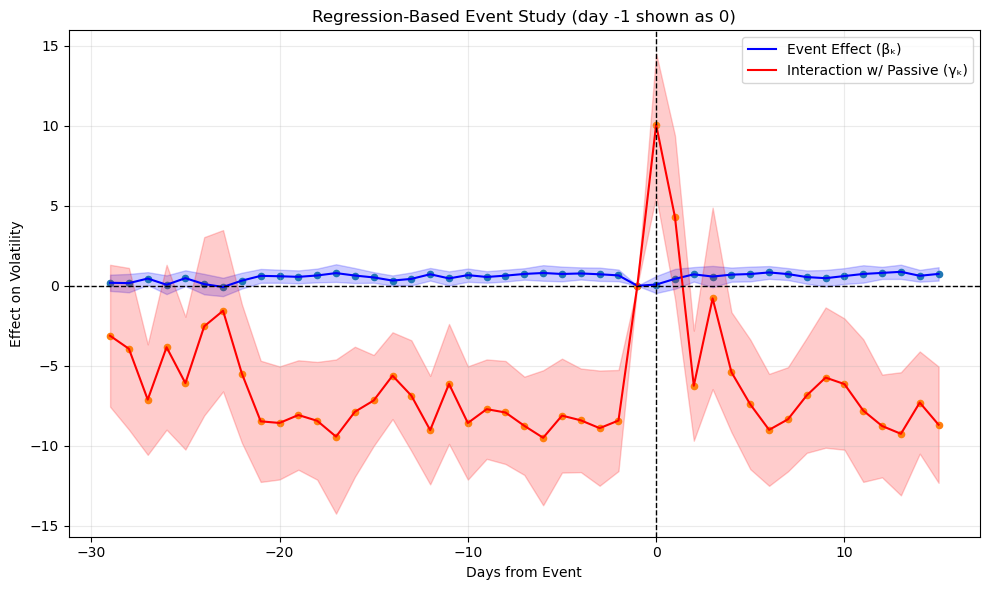

In [36]:
days = list(range(-29, 16))

def get_coef(key):
    return float(res2.params.get(key, 0.0))

def get_se(key):
    return float(res2.std_errors.get(key, 0.0))

# Build arrays for betas and gammas, with explicit 0 at day -1
betas = []
beta_se = []
gammas = []
gamma_se = []

for k in days:
    if k == -1:
        # omitted baseline: coefficient = 0, se = 0
        betas.append(0.0)
        beta_se.append(0.0)
        gammas.append(0.0)
        gamma_se.append(0.0)
    else:
        betas.append(get_coef(f'day_{k}'))
        beta_se.append(get_se(f'day_{k}'))
        gammas.append(get_coef(f'day_{k}_passive_hat'))
        gamma_se.append(get_se(f'day_{k}_passive_hat'))

betas = np.array(betas)
beta_se = np.array(beta_se)
gammas = np.array(gammas)
gamma_se = np.array(gamma_se)

# 95% CI bounds
beta_lower = betas - 1.96 * beta_se
beta_upper = betas + 1.96 * beta_se
gamma_lower = gammas - 1.96 * gamma_se
gamma_upper = gammas + 1.96 * gamma_se

# Plot: lines + shaded 95% CI + dots
plt.figure(figsize=(10,6))

# βk
plt.plot(days, betas, label='Event Effect (βₖ)', linewidth=1.5, color='blue')
plt.fill_between(days, beta_lower, beta_upper, alpha=0.2, color='blue')
plt.scatter(days, betas, s=20)

# γk
plt.plot(days, gammas, label='Interaction w/ Passive (γₖ)', linewidth=1.5, color='red')
plt.fill_between(days, gamma_lower, gamma_upper, alpha=0.2, color='red')
plt.scatter(days, gammas, s=20)

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.xlabel('Days from Event')
plt.ylabel('Effect on Volatility')
plt.title('Regression-Based Event Study (day -1 shown as 0)')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("Graphs/3vol_es_iv.png")
plt.show()

In [37]:
data_cont['passive_hat'] = x_hat

for k in range(-29, 16):
    data_cont[f'day_{k}'] = (data_cont['days_from_earn'] == k).astype(int)

for k in range(-29, 16):
    if k != -1:  
        data_cont[f'day_{k}_passive_hat'] = data_cont[f'day_{k}'] * data_cont['passive_hat']

event_dummies = [f'day_{k}' for k in range(-29, 16) if k != -1]
interaction_terms = [f'day_{k}_passive_hat' for k in range(-29, 16) if k != -1]

controls = ['passive_hat', 'ta', 'cash_sinvest', 'long_debt_tot', 'rev', 'net_inc', 'eps', 'vol']

X_vars = event_dummies + interaction_terms + controls

data_cont['Date'] = pd.to_datetime(data_cont['Date'])
df = data_cont.set_index(['ticker', 'Date'])

Y = df['5day_vol']
X = df[X_vars]

model2 = PanelOLS(Y, X, entity_effects=True, time_effects=False)
res2 = model2.fit(cov_type='clustered', cluster_entity=True)

print(res2.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               5day_vol   R-squared:                        0.0174
Estimator:                   PanelOLS   R-squared (Between):              0.1016
No. Observations:              328958   R-squared (Within):               0.0174
Date:                Sun, Nov 02 2025   R-squared (Overall):              0.0745
Time:                        19:15:51   Log-likelihood                -1.079e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      59.846
Entities:                        3502   P-value                           0.0000
Avg Obs:                       93.934   Distribution:               F(96,325360)
Min Obs:                       1.0000                                           
Max Obs:                       136.00   F-statistic (robust):             9.1849
                            

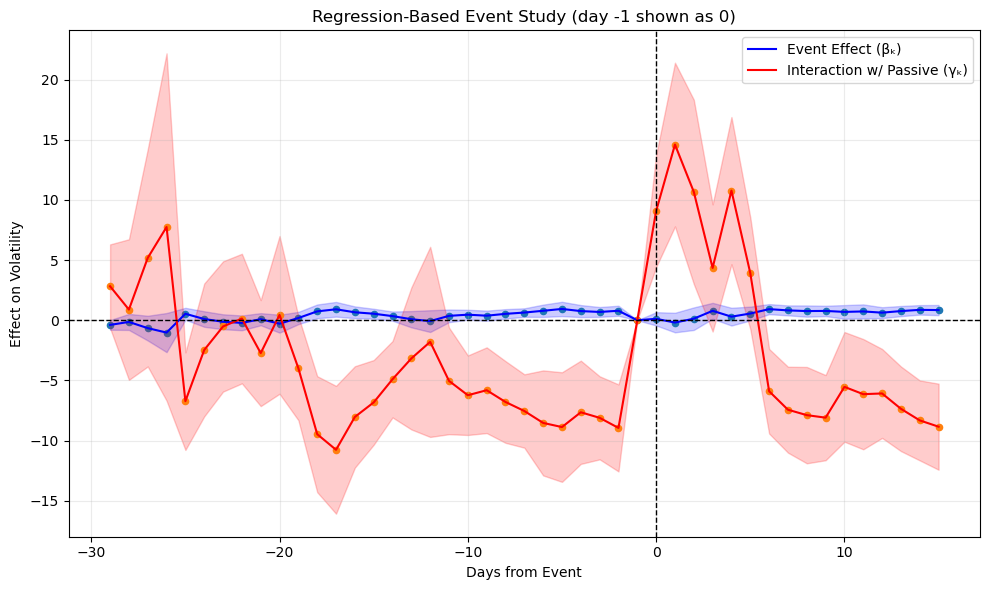

In [38]:
days = list(range(-29, 16))

def get_coef(key):
    return float(res2.params.get(key, 0.0))

def get_se(key):
    return float(res2.std_errors.get(key, 0.0))

# Build arrays for betas and gammas, with explicit 0 at day -1
betas = []
beta_se = []
gammas = []
gamma_se = []

for k in days:
    if k == -1:
        # omitted baseline: coefficient = 0, se = 0
        betas.append(0.0)
        beta_se.append(0.0)
        gammas.append(0.0)
        gamma_se.append(0.0)
    else:
        betas.append(get_coef(f'day_{k}'))
        beta_se.append(get_se(f'day_{k}'))
        gammas.append(get_coef(f'day_{k}_passive_hat'))
        gamma_se.append(get_se(f'day_{k}_passive_hat'))

betas = np.array(betas)
beta_se = np.array(beta_se)
gammas = np.array(gammas)
gamma_se = np.array(gamma_se)

# 95% CI bounds
beta_lower = betas - 1.96 * beta_se
beta_upper = betas + 1.96 * beta_se
gamma_lower = gammas - 1.96 * gamma_se
gamma_upper = gammas + 1.96 * gamma_se

# Plot: lines + shaded 95% CI + dots
plt.figure(figsize=(10,6))

# βk
plt.plot(days, betas, label='Event Effect (βₖ)', linewidth=1.5, color='blue')
plt.fill_between(days, beta_lower, beta_upper, alpha=0.2, color='blue')
plt.scatter(days, betas, s=20)

# γk
plt.plot(days, gammas, label='Interaction w/ Passive (γₖ)', linewidth=1.5, color='red')
plt.fill_between(days, gamma_lower, gamma_upper, alpha=0.2, color='red')
plt.scatter(days, gammas, s=20)

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.xlabel('Days from Event')
plt.ylabel('Effect on Volatility')
plt.title('Regression-Based Event Study (day -1 shown as 0)')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("Graphs/5vol_es_iv.png")
plt.show()

In [39]:
data_cont['passive_hat'] = x_hat

for k in range(-29, 16):
    data_cont[f'day_{k}'] = (data_cont['days_from_earn'] == k).astype(int)

for k in range(-29, 16):
    if k != -1:  
        data_cont[f'day_{k}_passive_hat'] = data_cont[f'day_{k}'] * data_cont['passive_hat']

event_dummies = [f'day_{k}' for k in range(-29, 16) if k != -1]
interaction_terms = [f'day_{k}_passive_hat' for k in range(-29, 16) if k != -1]

controls = ['passive_hat', 'ta', 'cash_sinvest', 'long_debt_tot', 'rev', 'net_inc', 'eps', 'vol']

X_vars = event_dummies + interaction_terms + controls

data_cont['Date'] = pd.to_datetime(data_cont['Date'])
df = data_cont.set_index(['ticker', 'Date'])

Y = df['7day_vol']
X = df[X_vars]

model2 = PanelOLS(Y, X, entity_effects=True, time_effects=False)
res2 = model2.fit(cov_type='clustered', cluster_entity=True)

print(res2.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:               7day_vol   R-squared:                        0.0155
Estimator:                   PanelOLS   R-squared (Between):              0.1223
No. Observations:              328958   R-squared (Within):               0.0155
Date:                Sun, Nov 02 2025   R-squared (Overall):              0.0877
Time:                        19:16:11   Log-likelihood                -1.174e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      53.216
Entities:                        3502   P-value                           0.0000
Avg Obs:                       93.934   Distribution:               F(96,325360)
Min Obs:                       1.0000                                           
Max Obs:                       136.00   F-statistic (robust):             9.0664
                            

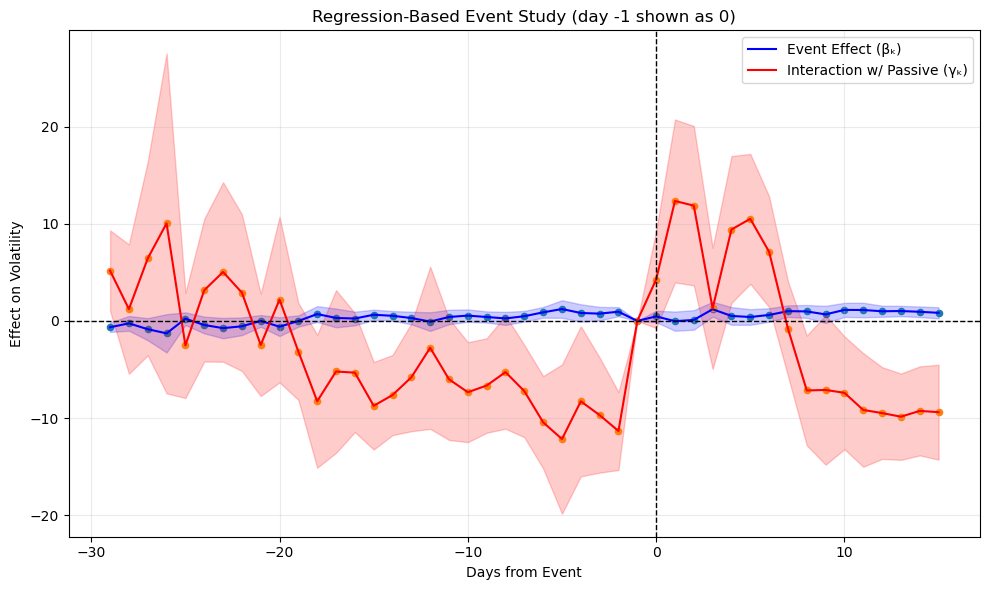

In [40]:
days = list(range(-29, 16))

def get_coef(key):
    return float(res2.params.get(key, 0.0))

def get_se(key):
    return float(res2.std_errors.get(key, 0.0))

# Build arrays for betas and gammas, with explicit 0 at day -1
betas = []
beta_se = []
gammas = []
gamma_se = []

for k in days:
    if k == -1:
        # omitted baseline: coefficient = 0, se = 0
        betas.append(0.0)
        beta_se.append(0.0)
        gammas.append(0.0)
        gamma_se.append(0.0)
    else:
        betas.append(get_coef(f'day_{k}'))
        beta_se.append(get_se(f'day_{k}'))
        gammas.append(get_coef(f'day_{k}_passive_hat'))
        gamma_se.append(get_se(f'day_{k}_passive_hat'))

betas = np.array(betas)
beta_se = np.array(beta_se)
gammas = np.array(gammas)
gamma_se = np.array(gamma_se)

# 95% CI bounds
beta_lower = betas - 1.96 * beta_se
beta_upper = betas + 1.96 * beta_se
gamma_lower = gammas - 1.96 * gamma_se
gamma_upper = gammas + 1.96 * gamma_se

# Plot: lines + shaded 95% CI + dots
plt.figure(figsize=(10,6))

# βk
plt.plot(days, betas, label='Event Effect (βₖ)', linewidth=1.5, color='blue')
plt.fill_between(days, beta_lower, beta_upper, alpha=0.2, color='blue')
plt.scatter(days, betas, s=20)

# γk
plt.plot(days, gammas, label='Interaction w/ Passive (γₖ)', linewidth=1.5, color='red')
plt.fill_between(days, gamma_lower, gamma_upper, alpha=0.2, color='red')
plt.scatter(days, gammas, s=20)

# Reference lines
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.xlabel('Days from Event')
plt.ylabel('Effect on Volatility')
plt.title('Regression-Based Event Study (day -1 shown as 0)')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("Graphs/7vol_es_iv.png")
plt.show()

In [41]:
data_pj = pd.read_csv('Data/master_data_pj.csv')
data_pj.drop(columns=["Unnamed: 0"], inplace=True)
data_pj = data_pj.dropna()
data_pj = data_pj.sort_values(['Date', 'ticker'])

In [42]:
sum_stats2 = data_pj[['price', 'vol', 'return', 'share_passive', 'PJ_ar1', 'PJ_mkt', 'PJ_sp']].describe()
sum_stats2

,price,vol,return,share_passive,PJ_ar1,PJ_mkt,PJ_sp
count,12247.000000,1.224700e+04,12247.000000,12247.000000,12247.000000,12247.000000,12247.000000
mean,60.783594,3.409727e+06,-0.000216,0.141363,8.961259,2.695337,3.040682
std,175.233314,1.169679e+07,0.067792,0.123504,403.738998,20.504926,46.026730
min,0.038800,0.000000e+00,-0.642470,0.000004,0.000069,0.000298,0.000388
25%,7.850000,2.080840e+05,-0.025318,0.042195,0.373075,0.383430,0.386526
50%,22.730000,7.629150e+05,-0.000616,0.119163,0.734039,0.744211,0.745343
75%,61.335000,2.473996e+06,0.022088,0.184405,1.374688,1.348301,1.354516
max,8064.090000,4.210580e+08,1.067376,0.939402,39261.779376,940.845537,4038.211130


In [43]:
data_pj = data_pj[(data_pj['PJ_ar1'] >= -3) & (data_pj['PJ_ar1'] <= 3)]
data_pj = data_pj[(data_pj['PJ_mkt'] >= -3) & (data_pj['PJ_mkt'] <= 3)]
data_pj = data_pj[(data_pj['PJ_sp'] >= -3) & (data_pj['PJ_sp'] <= 3)]

In [44]:
data_pj['passive_q'] = pd.qcut(data_pj['share_passive'], q=4, labels=False) + 1

In [45]:
avg_PJ_ar1 = (data_pj.groupby(['Date', 'passive_q'])['PJ_ar1'].mean().reset_index())
avg_PJ_ar1 = avg_PJ_ar1.sort_values(['Date'])

/var/folders/5b/jc4253hj4rl3y0jlxy2y3trm0000gn/T/ipykernel_93737/3132419513.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub1['Date'] = pd.to_datetime(sub1['Date'])
/var/folders/5b/jc4253hj4rl3y0jlxy2y3trm0000gn/T/ipykernel_93737/3132419513.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub2['Date'] = pd.to_datetime(sub2['Date'])
/var/folders/5b/jc4253hj4rl3y0jlxy2y3trm0000gn/T/ipykernel_93737/3132419513.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

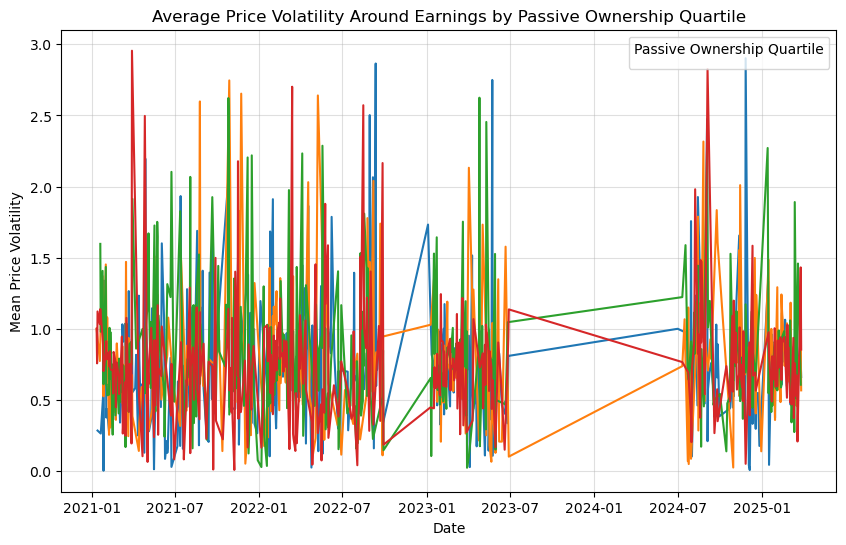

In [46]:
plt.figure(figsize=(10,6))
sub1 = avg_PJ_ar1[avg_PJ_ar1['passive_q'] == 1]
sub1['Date'] = pd.to_datetime(sub1['Date'])
plt.plot(sub1['Date'], sub1['PJ_ar1'])
sub2 = avg_PJ_ar1[avg_PJ_ar1['passive_q'] == 2]
sub2['Date'] = pd.to_datetime(sub2['Date'])
plt.plot(sub2['Date'], sub2['PJ_ar1'])
sub3 = avg_PJ_ar1[avg_PJ_ar1['passive_q'] == 3]
sub3['Date'] = pd.to_datetime(sub3['Date'])
plt.plot(sub3['Date'], sub3['PJ_ar1'])
sub4 = avg_PJ_ar1[avg_PJ_ar1['passive_q'] == 4]
sub4['Date'] = pd.to_datetime(sub4['Date'])
plt.plot(sub4['Date'], sub4['PJ_ar1'])

plt.title('Average Price Volatility Around Earnings by Passive Ownership Quartile')
plt.xlabel('Date')
plt.ylabel('Mean Price Volatility')
plt.legend(title='Passive Ownership Quartile')
plt.grid(True, alpha = 0.4)

plt.show()

In [47]:
#Stage one
X = data_pj[['share_passive']]
Z = sm.add_constant(data_pj[['in_sp']])
y = data_pj[['PJ_ar1']]
model1 = sm.OLS(X, Z)
model1_robust = model1.fit(cov_type='HC3')
x_hat = model1_robust.predict(Z)
print(model1_robust.summary())

                            OLS Regression Results                            
Dep. Variable:          share_passive   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     7048.
Date:                Sun, 02 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:16:13   Log-Likelihood:                 8608.8
No. Observations:                9950   AIC:                        -1.721e+04
Df Residuals:                    9948   BIC:                        -1.720e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1142      0.001    101.719      0.0

In [48]:
X_hat = sm.add_constant(x_hat)
model2 = sm.OLS(y,X_hat)
model2_robust = model2.fit(cov_type='HC3')
print(model2_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                 PJ_ar1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.835
Date:                Sun, 02 Nov 2025   Prob (F-statistic):             0.0502
Time:                        19:16:13   Log-Likelihood:                -8920.6
No. Observations:                9950   AIC:                         1.785e+04
Df Residuals:                    9948   BIC:                         1.786e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7339      0.013     54.526      0.0

In [49]:
#Stage one
X = data_pj[['share_passive']]
Z = sm.add_constant(data_pj[['in_sp']])
y = data_pj[['PJ_mkt']]
model1 = sm.OLS(X, Z)
model1_robust = model1.fit(cov_type='HC3')
x_hat = model1_robust.predict(Z)
print(model1_robust.summary())

                            OLS Regression Results                            
Dep. Variable:          share_passive   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     7048.
Date:                Sun, 02 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:16:13   Log-Likelihood:                 8608.8
No. Observations:                9950   AIC:                        -1.721e+04
Df Residuals:                    9948   BIC:                        -1.720e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1142      0.001    101.719      0.0

In [50]:
X_hat = sm.add_constant(x_hat)
model2 = sm.OLS(y,X_hat)
model2_robust = model2.fit(cov_type='HC3')
print(model2_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                 PJ_mkt   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4469
Date:                Sun, 02 Nov 2025   Prob (F-statistic):              0.504
Time:                        19:16:13   Log-Likelihood:                -8223.9
No. Observations:                9950   AIC:                         1.645e+04
Df Residuals:                    9948   BIC:                         1.647e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7317      0.012     59.145      0.0

In [51]:
#Stage one
X = data_pj[['share_passive']]
Z = sm.add_constant(data_pj[['in_sp']])
y = data_pj[['PJ_sp']]
model1 = sm.OLS(X, Z)
model1_robust = model1.fit(cov_type='HC3')
x_hat = model1_robust.predict(Z)
print(model1_robust.summary())

                            OLS Regression Results                            
Dep. Variable:          share_passive   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     7048.
Date:                Sun, 02 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:16:14   Log-Likelihood:                 8608.8
No. Observations:                9950   AIC:                        -1.721e+04
Df Residuals:                    9948   BIC:                        -1.720e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1142      0.001    101.719      0.0

In [52]:
X_hat = sm.add_constant(x_hat)
model2 = sm.OLS(y,X_hat)
model2_robust = model2.fit(cov_type='HC3')
print(model2_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                  PJ_sp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.109
Date:                Sun, 02 Nov 2025   Prob (F-statistic):              0.292
Time:                        19:16:14   Log-Likelihood:                -7989.8
No. Observations:                9950   AIC:                         1.598e+04
Df Residuals:                    9948   BIC:                         1.600e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7197      0.012     59.668      0.0

In [53]:
data_pj_cont = pd.read_csv('Data/master_data_pj_controls.csv')
data_pj_cont.drop(columns=["Unnamed: 0"], inplace=True)
data_pj_cont = data_pj_cont.dropna()

In [54]:
data_pj_cont = data_pj_cont[(data_pj_cont['PJ_ar1'] >= -3) & (data_pj_cont['PJ_ar1'] <= 3)]
data_pj_cont = data_pj_cont[(data_pj_cont['PJ_mkt'] >= -3) & (data_pj_cont['PJ_mkt'] <= 3)]
data_pj_cont = data_pj_cont[(data_pj_cont['PJ_sp'] >= -3) & (data_pj_cont['PJ_sp'] <= 3)]

In [55]:
#Stage one
df = data_pj_cont.copy()

df['Date'] = pd.to_datetime(df['Date'])

# Create sector dummies (drop first)
sector_dummies = pd.get_dummies(df['sector'], prefix='sector', drop_first=True, dtype=float)

# Combine with main data
df = pd.concat([df, sector_dummies], axis=1)

# Define variables
controls = ['ta', 'cash_sinvest', 'long_debt_tot', 'rev', 'net_inc', 'eps', 'vol']
instrument = ['in_sp']
Z_vars = instrument + controls + list(sector_dummies.columns)

# Keep only needed columns
Z = df[Z_vars].copy()
X = df['share_passive'].copy()

# Convert all to numeric (force coercion)
Z = Z.apply(pd.to_numeric, errors='coerce')
X = pd.to_numeric(X, errors='coerce')

# Drop rows with missing data
valid_rows = Z.notna().all(axis=1) & X.notna()
Z = Z.loc[valid_rows]
X = X.loc[valid_rows]

# Add constant
Z = sm.add_constant(Z)

# Fit first stage
model1 = sm.OLS(X, Z)
model1_robust = model1.fit(cov_type='HC3')

X_hat = model1_robust.fittedvalues

print(model1_robust.summary())

                            OLS Regression Results                            
Dep. Variable:          share_passive   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     389.7
Date:                Sun, 02 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:16:14   Log-Likelihood:                 7544.6
No. Observations:                8301   AIC:                        -1.505e+04
Df Residuals:                    8282   BIC:                        -1.492e+04
Df Model:                          18                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1074      0.006     18.783

/opt/anaconda3/envs/econ/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 17
  warnings.warn('covariance of constraints does not have full '


In [56]:
#second stage
y = df['PJ_ar1']
X_vars = pd.concat([X_hat, df[controls + list(sector_dummies.columns)]], axis=1)
X_vars = sm.add_constant(X_vars)
model2 = sm.OLS(y, X_vars)
model2_robust = model2.fit(cov_type='HC3')
print(model2_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                 PJ_ar1   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.131
Date:                Sun, 02 Nov 2025   Prob (F-statistic):            0.00433
Time:                        19:16:14   Log-Likelihood:                -7451.1
No. Observations:                8301   AIC:                         1.494e+04
Df Residuals:                    8282   BIC:                         1.507e+04
Df Model:                          18                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6795      0.031     21.943

/opt/anaconda3/envs/econ/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 17
  warnings.warn('covariance of constraints does not have full '


In [57]:
#second stage
y = df['PJ_mkt']
X_vars = pd.concat([X_hat, df[controls + list(sector_dummies.columns)]], axis=1)
X_vars = sm.add_constant(X_vars)
model2 = sm.OLS(y, X_vars)
model2_robust = model2.fit(cov_type='HC3')
print(model2_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                 PJ_mkt   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.785
Date:                Sun, 02 Nov 2025   Prob (F-statistic):             0.0242
Time:                        19:16:14   Log-Likelihood:                -6753.7
No. Observations:                8301   AIC:                         1.355e+04
Df Residuals:                    8282   BIC:                         1.368e+04
Df Model:                          18                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6745      0.028     24.449

/opt/anaconda3/envs/econ/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 17
  warnings.warn('covariance of constraints does not have full '


In [58]:
#second stage
y = df['PJ_sp']
X_vars = pd.concat([X_hat, df[controls + list(sector_dummies.columns)]], axis=1)
X_vars = sm.add_constant(X_vars)
model2 = sm.OLS(y, X_vars)
model2_robust = model2.fit(cov_type='HC3')
print(model2_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                  PJ_sp   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.545
Date:                Sun, 02 Nov 2025   Prob (F-statistic):             0.0700
Time:                        19:16:14   Log-Likelihood:                -6639.3
No. Observations:                8301   AIC:                         1.332e+04
Df Residuals:                    8282   BIC:                         1.345e+04
Df Model:                          18                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6635      0.028     23.781

/opt/anaconda3/envs/econ/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 17
  warnings.warn('covariance of constraints does not have full '
